# A Digital Twin Approach to World Cup Modelling

Prever resultados de jogos é um passatempo, e ganha pão, de muitos nerds, sendo a Copa do Mundo o maior troféu. Você consegue achar predições usando uma [grande](http://previsaoesportiva.com.br/campeonatos/copa2018/boxplot.html) [variedade](http://www.chancedegol.com.br/copa18.htm) de [modelos](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook) por aí, mas aqui vamos pensar em algo um pouco diferente. E se tivéssemos um Digital Twin de cada seleção?

[Um gêmeo digital é uma cópia digital de uma coisa física](https://en.wikipedia.org/wiki/Digital_twin). Como a cópia é digital, você pode usar ela para prever muitas coisas impraticáveis no mundo físico, como simular urubus entrando no digital twin de uma turbina de avião ou anteceder falhas em turbinas eólicas em locais inacessíveis.

É claro que definir esse bixo é muito mais fácil do que construir ele. Muita gente também vai se perguntar se isso não é a mesma coisa que as simulações da engenharia, ou machine learning e otimização. A resposta é: sim e não.

![Isso tem que ser falado](infelizmente.jpg)

Você forma um digital twin com um pouco de tudo isso aí. Um sistema de muitas partículas interagindo, como uma proteína, pode ser simulada através da descrição física de como cada um de seus vários atómos reage de acordo com variáveis do ambiente e interação com outros átomos. Em sistemas mais complicados, como pessoas conversando ou processos mais complexos, não temos o luxo de, partindo das leis da física, prever como uma pessoa vai agir. E daí entra o Machine Learning: aprendemos com o histórico como representar uma certa entidade e, depois, estamos livres para simular ela interagindo com o mundo e outras entidades.

No problema da Copa do Mundo temos duas possibilidades: podemos separar os dados de cada seleção e construir um modelo para cada, ou podemos fazer um grande preditor de resultado de jogos, olhando para todos os resultados de todos os jogos e, na hora do uso, alimentarmos essa máquina com somente os jogos de uma seleção para prever os seus resultados. A primeira abordagem é um pouco mais óbvia: jogos e dados do Brasil são usados para prever resultados do Brasil. Entretanto a segunda abordagem, mesmo que mais confusa, é mais rica: ela permite aproveitarmos todos os dados disponíveis e fazer previsões para o Brasil utilizando situações parecidas que ocorreram com outras seleções.

Em todo caso, é melhor avançarmos aos poucos. Na Seção 1 descrevo os dados que considerei na modelagem. Na Seção 2 faço um Digital Twin exclusivo com dados do Brasil e, na Seção 3, generalizo para construção de um Digital Twin de seleções.

# 1. Dados que eu peguei de outra pessoa

O usuário do Kaggle Agostonkorok já nos fez o grande favor de coletar os [principais dados](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook) utilizados na previsão de jogos de seleções. Temos três conjuntos.

O primeiro é o ranking da Fifa, que contém a posição de cada país com uma precisão absurda (mensal):

In [1]:
import pandas as pd

ranking_fifa = pd.read_csv("Data/fifa_ranking.csv")
print(ranking_fifa.shape)
ranking_fifa

(57793, 16)


,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.00,57,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
1,2,Italy,ITA,0.00,57,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
2,3,Switzerland,SUI,0.00,50,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
3,4,Sweden,SWE,0.00,55,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
4,5,Argentina,ARG,0.00,51,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONMEBOL,1993-08-08
5,6,Republic of Ireland,IRL,0.00,54,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
6,7,Russia,RUS,0.00,52,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
7,8,Brazil,BRA,0.00,55,-5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONMEBOL,1993-08-08
8,9,Norway,NOR,0.00,49,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08
9,10,Denmark,DEN,0.00,51,-1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1993-08-08


Tab. 1. Ranking da Fifa. Tem informação aí desde 1993, melhor que muito dado público que se vê por aí. 

O segundo é uma mistura de dados históricos sobre as seleções da copa atual e informações sobre os jogos da primeira fase:

In [2]:
world_cup = pd.read_csv("Data/World Cup 2018 Dataset.csv")
print(world_cup.shape)
world_cup.head(5)

(33, 20)


,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


Tab. 2: Resumo sobre as seleções da copa. Mas que excelente ideia colocar informações passadas e futuras na mesma tabela.

Por último, e mais importante, um resumo do resultado de todos os jogos entre seleções da história

In [3]:
game_result = pd.read_csv("Data/results.csv")
print(game_result.shape)
game_result.head(5)

(39045, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Tab. 3. Todos os jogos da história. Nessa tabela o Palmeiras também não tem mundial.

Nossos dados contém dois tipos de informação. As tabelas ranking_fifa e world_cup contém dados sobre o perfil da seleção, enquanto a tabela game_result contém uma espécie de linha do tempo de uma seleção. Essa distinção será muito importante para um Digital Twin, já que o queremos prever é uma continuação dessa linha do tempo.

# 2. Digital Twin do Brasil

Vamos filtrar os dados para considerar somente os jogos do Brasil no histórico. Vou desconsiderar informações de mandante de campo porque é difícil considerar isso em uma copa do mundo.

In [4]:
game_result_brasil_home = game_result[game_result['home_team'] == 'Brazil']
print(game_result_brasil_home.shape)

game_result_brasil_away = game_result[game_result['away_team'] == 'Brazil']
print(game_result_brasil_away.shape)

def vconcat_home_away_results(away_df,home_df):    
    
    results = pd.concat([away_df.rename(columns={'home_team' : 'team2','away_team':'team1',
                    'home_score': 'team2_score','away_score':'team1_score'}),\
                         home_df.rename(columns={'home_team' : 'team1','away_team':'team2',
                    'home_score': 'team1_score','away_score':'team2_score'})])
    
    results['AAAA-MM'] = results['date'].str[:7]
    
    return results.drop(['tournament','city','country','neutral'],axis=1)

game_results_brasil = vconcat_home_away_results(game_result_brasil_away,game_result_brasil_home)
print(game_results_brasil.shape)
game_results_brasil.head(5)

(548, 9)
(403, 9)
(951, 6)


,date,team1,team1_score,team2,team2_score,AAAA-MM
398,1914-09-20,Brazil,0,Argentina,3,1914-09
399,1914-09-27,Brazil,1,Argentina,0,1914-09
424,1916-07-10,Brazil,1,Argentina,1,1916-07
429,1916-07-18,Brazil,1,Uruguay,0,1916-07
454,1917-10-03,Brazil,2,Argentina,4,1917-10


Text(0,0.5,'Gols')

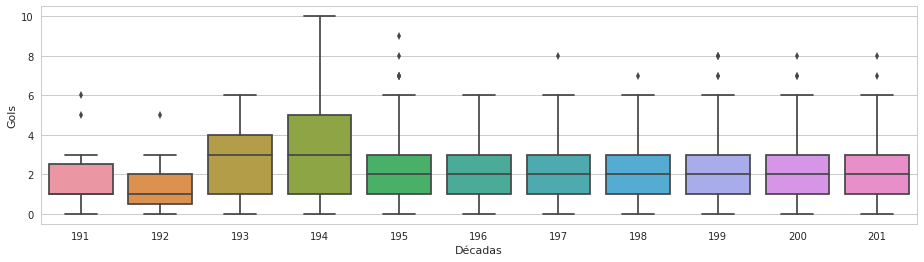

In [5]:
%matplotlib inline
import seaborn as sns

sns.set(rc={'figure.figsize':(15.7,4)})
sns.set_style("whitegrid")

ax = sns.boxplot(y=game_results_brasil['team1_score'], 
                 x=game_results_brasil['AAAA-MM'].str[:3])
ax.set_xlabel('Décadas')
ax.set_ylabel('Gols')

Tab. 4. Gols do Brasil ao longo das décadas. As coisas foram animadas mesmo nos anos 40.

Preciso de informações do ranking do Brasil (team1) e do adversário (team2) no momento do jogo. Essas são as informações de "perfil" dos nossos times, enquanto os jogos representam a linha do tempo da seleção.

Filtrar com a tabela de rankings da Fifa também ajuda a manter somente informações de jogos mais recentes.

In [6]:
ranking_fifa['AAAA-MM'] = ranking_fifa['rank_date'].str[:7]

game_results_rkteam1 = pd.merge(game_results_brasil, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['team1','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                       )

game_results_rk_brasil = pd.merge(game_results_rkteam1, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['team2','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                        suffixes=('','_away')
                       )

game_results_rk_brasil.shape

(342, 36)

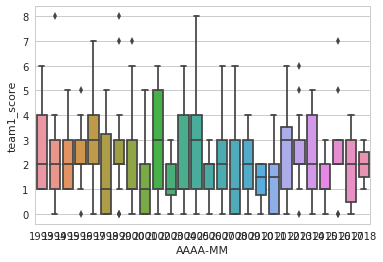

In [7]:
ax = sns.boxplot(y=game_results_rk_brasil['team1_score'], 
                 x=game_results_rk_brasil['AAAA-MM'].str[:4])

Com a tabela game_results_rk_brasil podemos começar a modelar. Aqui team1 representa o Brasil e team2 o adversário. Como temos poucos jogos, vamos tentar prever somente se houve vitória, derrota ou empate do Brasil.

In [8]:
def construct_target(df,team1_score_feature,team2_score_feature):    
    return df.apply(lambda row : 'WIN' if row[team1_score_feature] > row[team2_score_feature]
                                       else 'LOS' if row[team2_score_feature] > row[team1_score_feature]
                                       else 'DRW',axis=1)

game_results_rk_brasil['TARGET'] = construct_target(game_results_rk_brasil,'team1_score','team2_score')
game_results_rk_brasil[['team1_score','team2_score','TARGET']].head(5)

,team1_score,team2_score,TARGET
0,5,1,WIN
1,1,1,DRW
2,1,1,DRW
3,2,0,WIN
4,6,0,WIN


In [9]:
game_results_rk_brasil.groupby(by='TARGET').count()['date']

TARGET
DRW     70
LOS     48
WIN    224
Name: date, dtype: int64

Essas são as colunas úteis para modelarmos:

In [10]:
variables = ['rank', 'total_points', 'previous_points', 'rank_change', 'cur_year_avg', 'cur_year_avg_weighted', 'last_year_avg',
'last_year_avg_weighted', 'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg', 'three_year_ago_weighted']

variables = variables + [x+'_away' for x in variables]

Vamos testar então alguns classificadores para fazer a predição. Para cada classificador, testamos alguns parâmetros com um grid search:

In [22]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

def test_model(X,y,model,param_grid,fold,X_test=None,y_test=None,refit=True):    
    
    clf_grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv= fold, verbose = True, refit=refit)
    
    clf_grid.fit(X,y)
    
    best_acc = clf_grid.best_score_
    
    best_f1 = f1_score(clf_grid.best_estimator_.predict(X),y,average='weighted')
    
    print("\tbest acc = %.6f"%best_acc)
    print("\tbest f1 = %.6f"%best_f1)
    
    best_acc_test = 0
    best_f1_test = 0
    if X_test!=None and y_test!=None:
        y_pred= clf_grid.best_estimator_.predict(X_test)        
        
        best_acc_test = accuracy_score(y_pred,y_test,average='weighted')
        best_f1_test = f1_score(y_pred,y_test,average='weighted')
        
        print("\tbest TEST acc = %.6f"%best_acc_test)
        print("\tbest TEST f1 = %.6f"%best_f1_test)
    
        
    return {'estimator':clf_grid.best_estimator_, 'acc' : best_acc, 'f1' : best_f1, 
                                                  'acc_test' : best_acc_test, 'f1_test' : best_f1_test}

Como temos muito poucos dados, estratégias de fold ou holdout seriam muito sensíveis à escolha aleatória de dados. Por isso, vamos escolher os modelos com um LeaveOneOut. Vamos testar vários classificadores avaliando sua acurácia.

In [12]:
from sklearn.model_selection import LeaveOneOut

X = game_results_rk_brasil[variables]
y = game_results_rk_brasil['TARGET']

brasil_clf_dict = {}

## Decision Trees

In [23]:
from sklearn.tree import DecisionTreeClassifier 

dtc_candidates = {
    'min_samples_leaf' : list(range(1,100,5)),
    'max_depth' : list(range(2,100,5)) + [None],
    'class_weight' : [None,'balanced']
}

brasil_clf_dict['dt'] = test_model(X,y,DecisionTreeClassifier(),dtc_candidates,LeaveOneOut())

Fitting 342 folds for each of 840 candidates, totalling 287280 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 4112 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 11612 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 22112 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 35612 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 52112 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 71612 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 94112 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 119612 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 148112 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 179612 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 214112 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 251612 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 287280 out of 287280 | elapsed:  1.7min finished


	best acc = 0.654971
	best f1 = 0.791519


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Support Vector Machine, as multi-classifier

In [48]:
from sklearn.svm import SVC

svc_candidates = {
    'C' : [i/1000.0 for i in range(1,2000,4)],
}

brasil_clf_dict['svm'] = test_model(X,y,SVC(),svc_candidates,LeaveOneOut())

Fitting 342 folds for each of 500 candidates, totalling 171000 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2208 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 6208 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 11808 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 19008 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 27808 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 38208 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 50208 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 63808 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 79008 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 95808 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 114208 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 134208 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 155808 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 171000 out of 171000 | elapsed:  4.1min finished


	best acc = 0.654971
	best f1 = 0.791519


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Logistic Regression, One vs Rest

In [44]:
from sklearn.linear_model import LogisticRegression

lr_candidates = {
    'penalty' : ['l1','l2'],
    'C' : [x/10.0 for x in range(900,1110,1)],
    'class_weight' : [None,'balanced'],
    'multi_class' : ['ovr']
}

brasil_clf_dict['lr'] = test_model(X,y,LogisticRegression(),lr_candidates,LeaveOneOut())

Fitting 342 folds for each of 840 candidates, totalling 287280 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 7304 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 14304 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 23304 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 34304 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 47304 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-1)]: Done 62304 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 79304 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 98304 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 119304 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 142304 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 167304 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 194304 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 223304 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 254304 task

	best acc = 0.631579
	best f1 = 0.759325


## Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_candidates = {
    'min_samples_leaf' : list(range(1,100,5)),
    'max_depth' : [None],
    'class_weight' : [None,'balanced'],
    'n_estimators' : list(range(10,100,20))
}

brasil_clf_dict['rf'] = test_model(X,y,RandomForestClassifier(),rf_candidates,LeaveOneOut())

Fitting 342 folds for each of 200 candidates, totalling 68400 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1440 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 2934 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 5112 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 8417 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 12187 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 15635 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 20139 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 25243 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 31219 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 37027 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 44687 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 52099 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 60199 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 68369 out of 68400 | elapsed:  5.7min remaining:    0.2s
[Parallel(n_jobs=-1)]: Do

	best acc = 0.657895
	best f1 = 0.787639


## Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gb_candidates = {
    'min_samples_leaf' : list(range(1,100,10)),
    'max_depth' : [None],
    'n_estimators' : list(range(10,100,20)),
    'learning_rate' : [0.001,0.01,0.1,1.0]
}

brasil_clf_dict['gb'] = test_model(X,y,GradientBoostingClassifier(),gb_candidates,LeaveOneOut())

Fitting 342 folds for each of 200 candidates, totalling 68400 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 778 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 1578 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2445 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3461 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5652 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 8600 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 12248 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 17254 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 18558 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 20499 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 24608 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 30408 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 35457 tasks      | elaps

	best acc = 0.669591
	best f1 = 0.771637


## Perceptron

In [30]:
from sklearn.neural_network import MLPClassifier

mlp_candidates = {
    'alpha' : [0.001,0.01] + [i/10.0 for i in range(1,11,3)],
    'learning_rate' : ['invscaling', 'adaptive'],
    'activation' : ['logistic', 'tanh', 'relu'],
    'max_iter' : [1000]
}

brasil_clf_dict['mlp'] = test_model(X,y,MLPClassifier(),mlp_candidates,LeaveOneOut())

Fitting 342 folds for each of 63 candidates, totalling 21546 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 11218 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 12768 tasks      | elapsed: 23

	best acc = 0.657895
	best f1 = 0.782625


## Fanático (chuta tudo como 'WIN')

In [32]:
from sklearn.dummy import DummyClassifier

dummy_candidates = {'strategy' : ['most_frequent']}

brasil_clf_dict['fan'] = test_model(X,y,DummyClassifier(),dummy_candidates,LeaveOneOut())

Fitting 342 folds for each of 1 candidates, totalling 342 fits
	best acc = 0.654971
	best f1 = 0.791519


[Parallel(n_jobs=-1)]: Done 342 out of 342 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Summary

In [49]:
clf_list= []
for key in brasil_clf_dict:
     clf_list.append({'classifier' : key , 'acc' : brasil_clf_dict[key]['acc'], 'f1' : brasil_clf_dict[key]['f1']})

brasil_clf_df = pd.DataFrame(clf_list)

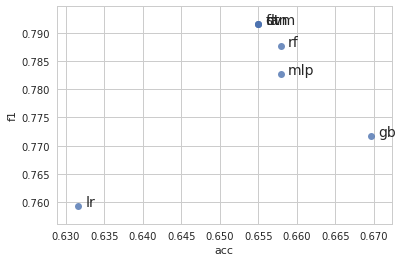

In [50]:
ax = sns.regplot(x=brasil_clf_df["acc"], y=brasil_clf_df["f1"],fit_reg=False)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.001, point['y'], str(point['val']),size=14)

label_point(brasil_clf_df["acc"], brasil_clf_df["f1"], brasil_clf_df["classifier"], ax) 

Enquanto o SVM empataca com o classificador Fanático na liderança em F1, o GradientBoosting supera todos em termo de acurácia. Perceba entretanto a escala dos gráficos: a distância entre a acurácia do Fanático e do campeão é de apenas 0.015 pp, ou seja, 5 jogos classificados errados e ambos já seriam equivalentes. Isso indica que nossos dados não são muito bons para prever o desempenho em uma partida. 

Alguns fatores podem estar contribuindo para isso, em que o mais importante parece ser a baixa quantidade de linhas. E essa é a principal desvantagem de fazermos um Digital Twin de um país apenas: nossos classificadores não tem dados o suficiente para aprender algum padrão.

# 3. Digital Twin das seleções

Como usar somente os dados de uma seleção para prever resultados é muito ruim, vamos utilizar os dados de todas.

In [51]:
ranking_fifa['AAAA-MM'] = ranking_fifa['rank_date'].str[:7]
game_result['AAAA-MM'] = game_result['date'].str[:7]
    
game_results_hometeam = pd.merge(game_result.drop(['tournament','city','country','neutral'],axis=1), 
                                 ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['home_team','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                       )

game_results_rk = pd.merge(game_results_hometeam, ranking_fifa.drop('country_abrv',axis=1),
                        left_on=['away_team','AAAA-MM'],
                        right_on = ['country_full','AAAA-MM'],
                        how='inner',
                        suffixes=('','_away')
                       )

game_results_rk.shape

(17308, 36)

In [52]:
game_results_rk['TARGET'] = construct_target(game_results_rk,'home_score','away_score')

Como temos muitos dados, podemos separar um conjunto de testes (20%) e escolher os modelos baseados em um kfold de 5 grupos, refitando o modelo com melhor parametro no conjunto todo de treino ao final.

In [54]:
X_train, X_test,y_train,y_test = train_test_split(game_results_rk[variables], game_results_rk['TARGET'],
                                                  test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13846, 24)
(3462, 24)
(13846,)
(3462,)


In [ ]:
all_clf_dict =  {}

## Decision Trees

In [59]:
dtc_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : list(range(2,100)) + [None],
    'class_weight' : [None,'balanced']
}

all_clf_dict['dt'] = test_model(X_train,y_train,DecisionTreeClassifier(),dtc_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

Fitting 5 folds for each of 19602 candidates, totalling 98010 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 4448 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 7148 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 10448 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 14348 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 18848 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 23948 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 29648 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 35948 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 42848 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 50348 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 56615 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 60965 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 65615 tasks      | 

In [60]:
print('Best score for dt:', clf.best_score_) 
print('Best min_samples_leaf:',clf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',clf.best_estimator_.max_depth)
print('Best class_weight:',clf.best_estimator_.class_weight)

Best score for dt: 0.5749674996388848
Best min_samples_leaf: 89
Best max_depth: 7
Best class_weight: None


In [61]:
from sklearn.metrics import accuracy_score

y_pred = clf.best_estimator_.predict(X_test)

test_acc_clf = accuracy_score(y_test,y_pred)
test_acc_clf

0.5774119006354709

In [62]:
all_clf_df = all_clf_df.append({'classifier' : 'dt',
                                      'estimator':clf.best_estimator_, 
                                      'train_acc' : clf.best_score_,
                                      'test_acc' : test_acc_clf}, ignore_index=True)
all_clf_df.head(5)

,classifier,estimator,train_acc,test_acc
0,dt,"DecisionTreeClassifier(class_weight=None, crit...",0.574967,0.577412


## Support Vector Machine, as multi-classifier

In [63]:
svc_candidates = {
    'C' : [i/1000.0 for i in range(1,2000,1)],
}

all_clf_dict['svc'] = test_model(X_train,y_train,SVC(),dtc_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

Fitting 5 folds for each of 1999 candidates, totalling 9995 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 52.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 71.8min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 94.4min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 120.3min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 149.3min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 187.3min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 235.1min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 294.1min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 359.9min
[Parallel(n_jobs=-1)]: Done 9995 out of 9995 | elapsed: 370.8min finished


In [64]:
print('Best score for svcclf:', svcclf.best_score_) 
print('Best C:',svcclf.best_estimator_.C) 
print('Best kernel:',svcclf.best_estimator_.kernel)
print('Best class_weight:',svcclf.best_estimator_.class_weight)

Best score for svcclf: 0.48894987722085803
Best C: 0.997
Best kernel: rbf
Best class_weight: None


In [65]:
y_pred = svcclf.best_estimator_.predict(X_test)

test_acc_svcclf = accuracy_score(y_test,y_pred)
test_acc_svcclf

0.4855574812247256

In [66]:
all_clf_df = all_clf_df.append({'classifier' : 'svm',
                                      'estimator':svcclf.best_estimator_, 
                                      'train_acc' : svcclf.best_score_,
                                      'test_acc' : test_acc_svcclf}, ignore_index=True)

## Logistic Regression, One vs Rest

In [67]:
lr_candidates = {
    'penalty' : ['l1','l2'],
    'C' : [x/10.0 for x in range(900,1110,1)],
    'class_weight' : [None,'balanced'],
    'multi_class' : ['ovr']
}

all_clf_dict['lr'] = test_model(X_train,y_train,LogisticRegression(),lr_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4200 out of 4200 | elapsed:  5.3min finished


In [68]:
print('Best score for lrclf:', lrclf.best_score_) 
print('Best C:',lrclf.best_estimator_.C) 
print('Best penalty:',lrclf.best_estimator_.penalty)
print('Best class_weight:',lrclf.best_estimator_.class_weight)

Best score for lrclf: 0.5899176657518417
Best C: 97.4
Best penalty: l2
Best class_weight: None


In [69]:
y_pred = lrclf.best_estimator_.predict(X_test)

test_acc_lrclf = accuracy_score(y_test,y_pred)
test_acc_lrclf

0.5872328134026574

In [70]:
all_clf_df = all_clf_df.append({'classifier' : 'lr',
                                      'estimator':lrclf.best_estimator_, 
                                      'train_acc' : lrclf.best_score_,
                                      'test_acc' : test_acc_lrclf}, ignore_index=True)

## Random Forest

In [71]:
rf_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : [None],
    'class_weight' : [None,'balanced'],
    'n_estimators' : list(range(10,100,10))
}

all_clf_dict['rf'] = test_model(X_train,y_train,RandomForestClassifier(),rf_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

Fitting 5 folds for each of 1782 candidates, totalling 8910 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 8910 out of 8910 | elapsed:  7.2min finished


In [72]:
print('Best score for rfclf:', rfclf.best_score_) 
print('Best min_samples_leaf:',rfclf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',rfclf.best_estimator_.max_depth)
print('Best class_weight:',rfclf.best_estimator_.class_weight)
print('Best n_estimators:',rfclf.best_estimator_.n_estimators)

Best score for rfclf: 0.589989888776542
Best min_samples_leaf: 11
Best max_depth: None
Best class_weight: None
Best n_estimators: 80


In [73]:
y_pred = rfclf.best_estimator_.predict(X_test)

test_acc_rfclf = accuracy_score(y_test,y_pred)
test_acc_rfclf

0.5878105141536684

In [74]:
all_clf_df = all_clf_df.append({'classifier' : 'rf',
                                      'estimator':rfclf.best_estimator_, 
                                      'train_acc' : rfclf.best_score_,
                                      'test_acc' : test_acc_rfclf}, ignore_index=True)

## Gradient Boosting

In [75]:
from sklearn.ensemble import GradientBoostingClassifier

gb_candidates = {
    'min_samples_leaf' : list(range(1,100)),
    'max_depth' : [None],
    'n_estimators' : list(range(10,100,10)),
    'learning_rate' : [0.001,0.01,0.1,0.5,1.0]
}

all_clf_dict['gb'] = test_model(X_train,y_train,GradientBoostingClassifier(),gb_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

Fitting 5 folds for each of 4455 candidates, totalling 22275 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 61.2min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 83.0min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 101.9min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 118.9min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 134.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 149.4min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 163.5min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 244.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 290.8min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 319.3min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 341.4min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 441.8min
[Parallel(n_jobs=-1)]: Done 11218 tasks      | elapsed: 492.0min
[Parallel(n_jobs=-1)]: Done 12768 tasks      | 

In [76]:
print('Best score for gbclf:', gbclf.best_score_) 
print('Best min_samples_leaf:',gbclf.best_estimator_.min_samples_leaf) 
print('Best max_depth:',gbclf.best_estimator_.max_depth)
print('Best n_estimators:',gbclf.best_estimator_.n_estimators)

Best score for gbclf: 0.5885454282825364
Best min_samples_leaf: 93
Best max_depth: None
Best n_estimators: 20


In [77]:
y_pred = gbclf.best_estimator_.predict(X_test)

test_acc_gbclf = accuracy_score(y_test,y_pred)
test_acc_gbclf

0.5921432697862508

In [78]:
all_clf_df = all_clf_df.append({'classifier' : 'gb',
                                      'estimator':gbclf.best_estimator_, 
                                      'train_acc' : gbclf.best_score_,
                                      'test_acc' : test_acc_gbclf}, ignore_index=True)

## Perceptron

In [79]:
from sklearn.neural_network import MLPClassifier

mlp_candidates = {
    'alpha' : [0.001,0.01] + [i/10.0 for i in range(1,11)],
    'learning_rate' : ['constant','invscaling', 'adaptive'],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'max_iter' : [1000]
}

all_clf_dict['gb'] = test_model(X_train,y_train,MLPClassifier(),mlp_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  8.6min finished


In [80]:
print('Best score for mlpclf:', mlpclf.best_score_) 
print('Best alpha:',mlpclf.best_estimator_.alpha) 
print('Best learning_rate:',mlpclf.best_estimator_.learning_rate)
print('Best activation:',mlpclf.best_estimator_.activation)

Best score for mlpclf: 0.587895421060234
Best alpha: 0.3
Best learning_rate: invscaling
Best activation: logistic


In [81]:
y_pred = mlpclf.best_estimator_.predict(X_test)

test_acc_mlpclf = accuracy_score(y_test,y_pred)
test_acc_mlpclf

0.58578856152513

In [82]:
all_clf_df = all_clf_df.append({'classifier' : 'mlp',
                                      'estimator':mlpclf.best_estimator_, 
                                      'train_acc' : mlpclf.best_score_,
                                      'test_acc' : test_acc_mlpclf}, ignore_index=True)

## Fanático (chuta tudo como 'WIN')

In [83]:
from sklearn.dummy import DummyClassifier

dummy_candidates = {'strategy' : ['most_frequent']}

all_clf_dict['fan'] = test_model(X_train,y_train,DummyClassifier(),dummy_candidates,5,
                                   refit=True,X_test=X_test,y_test=y_test)

In [84]:
train_acc_naive= dumclf.score(X_train,y_train)

0.48454427271414124

In [85]:
y_test_pred = dumclf.predict(X_test)
test_acc_naive = accuracy_score(y_test,y_test_pred)
test_acc_naive

0.4855574812247256

In [86]:
all_clf_df = all_clf_df.append({'classifier' : 'naive', 
                                      'estimator' : dumclf, 
                                      'train_acc' : train_acc_naive,
                                      'test_acc' : test_acc_naive}, ignore_index=True)

## Summary

In [87]:
all_clf_list= []
for key in all_clf_dict:
     all_clf_list.append({'classifier' : key, 
                           'train_acc' : all_clf_dict[key]['acc'], 
                           'train_f1' : all_clf_dict[key]['f1'],
                           'test_acc' : all_clf_dict[key]['test_acc'], 
                           'test_f1' : all_clf_dict[key]['test_f1']})

all_clf_df = pd.DataFrame(all_clf_list)

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


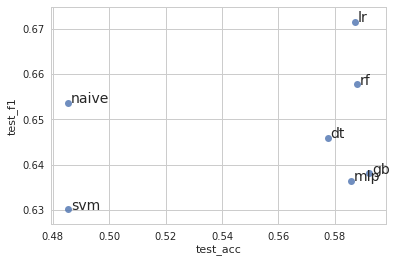

In [92]:
ax = sns.regplot(x=all_clf_df["test_acc"], y=all_clf_df["test_f1"],fit_reg=False)

label_point(all_clf_df["test_acc"], all_clf_df["test_f1"], all_clf_df["classifier"], ax) 

Ao final, parece que nossa simples regressão logítica é a campeão em termos de Acurácia e F1. Mais importante que isso, vários modelos conseguiram ganhos significativos de acurácia em relação fanático, o que mostra ser possível modelar com os dados totais, ao contrário do caso específico do Brasil.

# Campeão das seleções aplicado ao Brasil

In [45]:
dt_selecoes= all_clf_df[all_clf_df['key']='lr']['estimator'][0]

y_brasil_pred = dt_selecoes.predict(X)

dt_acc = accuracy_score(y_brasil_pred,y,average='weighted')
dt_f1 = f1_score(y_brasil_pred,y,average='weighted')

NameError: name 'all_clf_df' is not defined

In [ ]:
all_clf_df = all_clf_df.append({'classifier' : 'DT', 
                                      'estimator' : dt_selecoes, 
                                      'test_acc' : dt_acc,
                                      'test_f1' : dt_f1}, ignore_index=True)

In [ ]:
ax = sns.regplot(x=brasil_clf_df["test_acc"], y=brasil_clf_df["test_f1"],fit_reg=False)

label_point(brasil_clf_df["test_acc"], brasil_clf_df["test_f1"], brasil_clf_df["classifier"], ax) 